In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')
data_small_dir = os.path.join(project_root, 'synth_data')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, simple_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-27 10:57:53.213972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737971873.224232  529340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737971873.227357  529340 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 10:57:53.239039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1737971875.456472  529340 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 65

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [3]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')
test_synth_dir = os.path.join(data_small_dir, 'test')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE
temperature = 0.15

In [5]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
validation_dataset = get_augmented_dataset(val_dir,batch_size=32,shuffle=False)
test_dataset = get_augmented_dataset(test_dir,batch_size=32,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=False)
test_synth_dataset = get_augmented_dataset(test_synth_dir,batch_size=1,shuffle=False)



Found 73230 files belonging to 2 classes.
Found 36545 files belonging to 2 classes.
Found 19343 files belonging to 2 classes.
Found 399 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [6]:
validation_dataset = get_augmented_dataset(val_dir,batch_size=32,shuffle=False)

Found 36545 files belonging to 2 classes.


In [7]:
test_dataset = get_augmented_dataset(test_dir,batch_size=32)

Found 19343 files belonging to 2 classes.


In [8]:
from models import get_fcn_model,get_supervised_contrastive_loss
fcn_modelsimple = get_fcn_model(simple_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2)



In [ ]:
fcn_modelsimple.summary()

In [9]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [10]:

fcn_modelsimple.compile(
    optimizer=optimizer,
    loss=get_supervised_contrastive_loss(0.15)
)


change back to python to train:

In [11]:
import os
from models import get_fcn_model,get_supervised_contrastive_loss
fcn_modelb = fcn_modelsimple.fit(train_dataset,epochs=15)

Epoch 1/15


I0000 00:00:1737942663.270883  775447 service.cc:148] XLA service 0x7d0430003f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737942663.270966  775447 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-27 02:51:03.353098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737942663.535534  775447 cuda_dnn.cc:529] Loaded cuDNN version 90700


   9/2289 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - loss: 3.4082

I0000 00:00:1737942667.064216  775447 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 993/2289 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step - loss: 3.1555

KeyboardInterrupt: 

In [18]:
features=fcn_modelb.predict(test_dataset)

605/605 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step


In [19]:
import numpy as np
labels_total=[]
for batch_inputs, batch_labels in test_dataset:
    labels_total.append(batch_labels)
labels_ohe = np.concatenate(labels_total, axis=0)
labels_int = np.argmax(labels_ohe, axis=1)

2025-01-26 16:01:55.734791: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
#create traindataset for catboost
train_data_gbm=[]
train_label_gbm=[]
for batch_inputs, batch_labels in train_dataset:
    train_data_gbm.append(fcn_modelsimple.predict(batch_inputs))
    train_label_gbm.append(batch_labels)
#train_labels_xgb_ohe = np.concatenate(train_label_gbm, axis=0)
#train_labels_xgb_int = np.argmax(train_label_gbm, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

2025-01-26 16:04:39.121618: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
#create traindataset for catboost
test_data_gbm=[]
test_label_gbm=[]
for batch_inputs, batch_labels in test_dataset:
    test_data_gbm.append(fcn_modelsimple.predict(batch_inputs))
    test_label_gbm.append(batch_labels)
#train_labels_xgb_ohe = np.concatenate(train_label_gbm, axis=0)
#train_labels_xgb_int = np.argmax(train_label_gbm, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━

In [53]:
print(len(validation_dataset))

1143


In [58]:
#create traindataset for catboost\
from tqdm.notebook import tqdm
val_data_gbm = []
val_label_gbm = []
for features, labels in tqdm(validation_dataset):
    val_data_gbm.append(fcn_modelsimple.predict(features))
    val_label_gbm.append(labels)

  0%|          | 0/1143 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

2025-01-26 16:27:22.153323: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
import numpy as np

def combine_batches(features, labels):
    """
    Combine batched features and labels into a single set for XGBoost.
    
    Parameters
    ----------
    features : np.ndarray
        Feature array of shape (num_batches, batch_size, num_features)
    labels : np.ndarray
        Label array of shape (num_batches, batch_size, num_label_classes)
    
    Returns
    -------
    X : np.ndarray
        Combined feature array of shape (num_batches * batch_size, num_features)
    y : np.ndarray
        Combined label array of shape (num_batches * batch_size, num_label_classes)
    """
    # Check that the number of batches is the same for features and labels
    if features.shape[0] != labels.shape[0]:
        raise ValueError("The number of batches in features and labels must be the same.")
    
    num_features = features.shape[-1]
    X = features.reshape(-1, num_features)
    
    # Reshape labels and convert from one-hot to class indices.
    num_classes = labels.shape[-1]
    labels_reshaped = labels.reshape(-1, num_classes)
    y = np.argmax(labels_reshaped, axis=1)
    
    return X, y



In [55]:
len(val_data_gbm)

2286

In [61]:
from sklearn.model_selection import train_test_split
X_train, y_train = combine_batches(np.asarray(train_data_gbm[:-1]),np.asarray(train_label_gbm[:-1]))
np.shape(X_train)

(73216, 128)

In [48]:
np.shape(val_data_gbm[0])

(32, 128)

In [59]:
X_val, y_val = combine_batches(np.asarray(val_data_gbm[:-1]),np.asarray(val_label_gbm[:-1]))
np.shape(X_val)

(36544, 128)

In [60]:
X_test, y_test = combine_batches(np.asarray(test_data_gbm[:-1]),np.asarray(test_label_gbm[:-1]))

In [62]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
from xgboost import XGBClassifier

# Split the data into training and validation sets


# Create an XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(    X_train, y_train,
    eval_set=[ (X_val, y_val)],           # or another metric suited to your problem         # stops training if validation metric doesn't improve for 10 rounds
    verbose=False)
print("Model parameters:")
print(model.get_params())
y_pred = model.predict(X_test)
mcoeff = matthews_corrcoef(y_test, y_pred)
print("Mathew Coeff", mcoeff)
confusion_matrix(y_test,y_pred)


Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Mathew Coeff 0.9730786766737475


array([[10615,   148],
       [  109,  8456]])

In [63]:

# Predict on the validation set
y_pred = model.predict(X_val)

# Compute the indices of the misclassified samples
misclassified_indices = np.where(y_pred != y_val)[0]

# Retrieve the misclassified samples from the validation set
misclassified_samples = X_val[misclassified_indices]

# Retrieve the true labels and predicted labels for those samples, if desired
misclassified_true_labels = y_val[misclassified_indices]
misclassified_pred_labels = y_pred[misclassified_indices]

print("Misclassified sample indices:", misclassified_indices)
print("Number of misclassified samples:", len(misclassified_indices))
print("True labels for misclassified samples:", misclassified_true_labels)
print("Predicted labels for misclassified samples:", misclassified_pred_labels)

Misclassified sample indices: [ 4588  6523 11699 11766 14907 17980 19002 19004 19010 19013 19016 19019
 19027 19033 19035 19036 19042 19043 19046 19055 19057 19061 19062 19063
 19064 19065 19081 19085 19087 19094 19112 19115 19117 19118 19119 19121
 19127 19128 19131 19134 19138 19139 19144 19147 19149 19154 19159 19161
 19162 19175 19181 19182 19183 19184 19187 19189 19192 19193 19194 19196
 19202 19216 19225 19226 19229 19230 19233 19235 19236 19241 19255 19263
 19264 19265 19267 19271 19273 19277 19278 19283 19284 19286 19297 19305
 19306 19307 19325 19329 19340 19341 19342 19344 19345 19347 19354 19361
 19365 19367 19368 19371 19373 19376 19377 19387 19403 19407 19414 19417
 19433 19437 19439 19446 19456 19461 19466 19477 19487 19491 19496 19520
 19546 19578 19598 19601 19602 19605 19617 19618 19621 19628 19631 19632
 19678 19679 19680 19694 19701 19719 19721 19731 19748 19771 19773 19790
 19813 19822 19829 19838 19846 19858 19866 19904 19907 19917 19923 19928
 19941 19943 19946 19

Feature Importance (by Gain):
{'f0': 2.2518930435180664, 'f1': 4.09952449798584, 'f2': 43.96968460083008, 'f3': 9.479156494140625, 'f7': 3.123342990875244, 'f11': 22.87471580505371, 'f14': 2.4207992553710938, 'f15': 2.8678553104400635, 'f17': 2.6864261627197266, 'f23': 2.2998716831207275, 'f28': 33.804107666015625, 'f32': 2.3015947341918945, 'f33': 2.8855764865875244, 'f34': 4.163889408111572, 'f37': 2.3744564056396484, 'f58': 1.9087300300598145, 'f61': 2.3372740745544434, 'f67': 2.7124199867248535, 'f68': 2.5087647438049316, 'f70': 2.416226387023926, 'f71': 2.6805264949798584, 'f83': 4.323258399963379, 'f84': 45.4217643737793, 'f96': 1741.9569091796875, 'f108': 3.114542007446289, 'f113': 8.771594047546387, 'f124': 2.3425533771514893, 'f126': 2.8162965774536133}
Feature Importances:
{'f0': 2.2518930435180664, 'f1': 4.09952449798584, 'f2': 43.96968460083008, 'f3': 9.479156494140625, 'f7': 3.123342990875244, 'f11': 22.87471580505371, 'f14': 2.4207992553710938, 'f15': 2.8678553104400635, 

<Figure size 1000x1000 with 0 Axes>

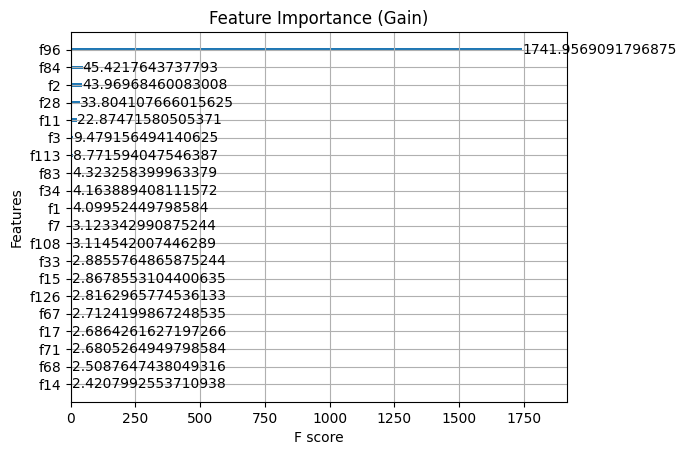

In [64]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
booster = model.get_booster()
importances = booster.get_score(importance_type='gain')
print("Feature Importance (by Gain):")
print(importances)
print("Feature Importances:")
print(importances)

plt.figure(figsize=(10, 10))

plot_importance(model,max_num_features=20, importance_type='gain', title="Feature Importance (Gain)")
plt.show()

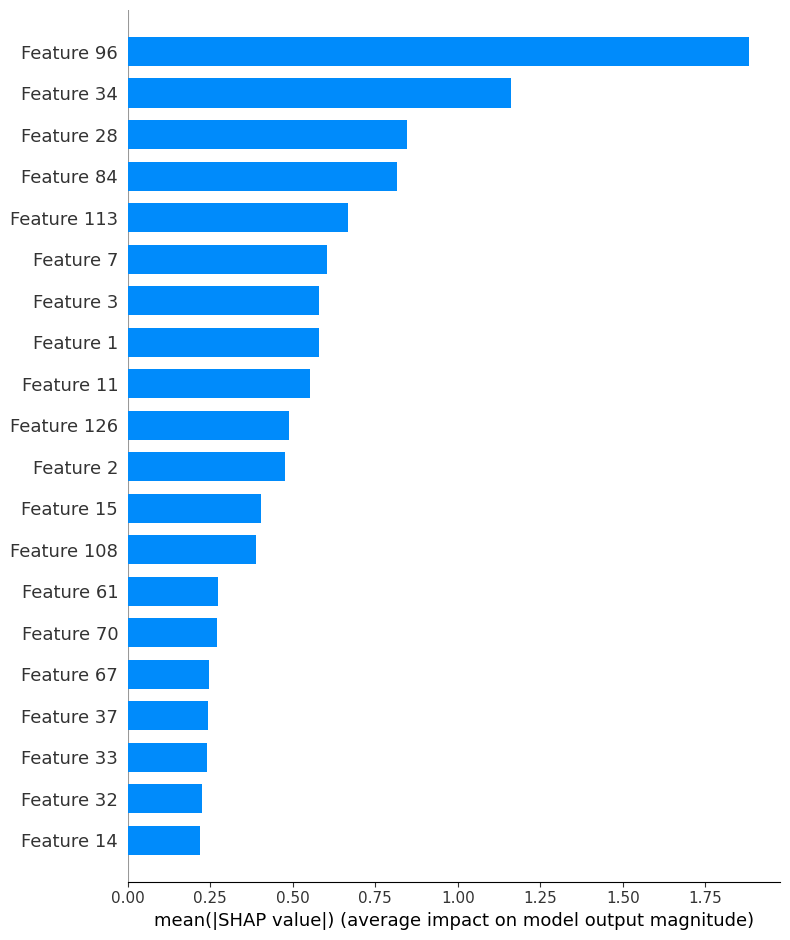

In [65]:
import shap
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for your validation set (or use X_train as needed)
shap_values = explainer.shap_values(X_val)

# For binary classification, shap_values might be a list of two arrays,
# one for each class. Typically, we use the values for the positive class.
if isinstance(shap_values, list):
    # Use SHAP values for class 1, e.g. the "positive" class
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Generate a bar summary plot of the top 20 most important features
shap.summary_plot(shap_values_to_plot, X_val, plot_type="bar", max_display=20)

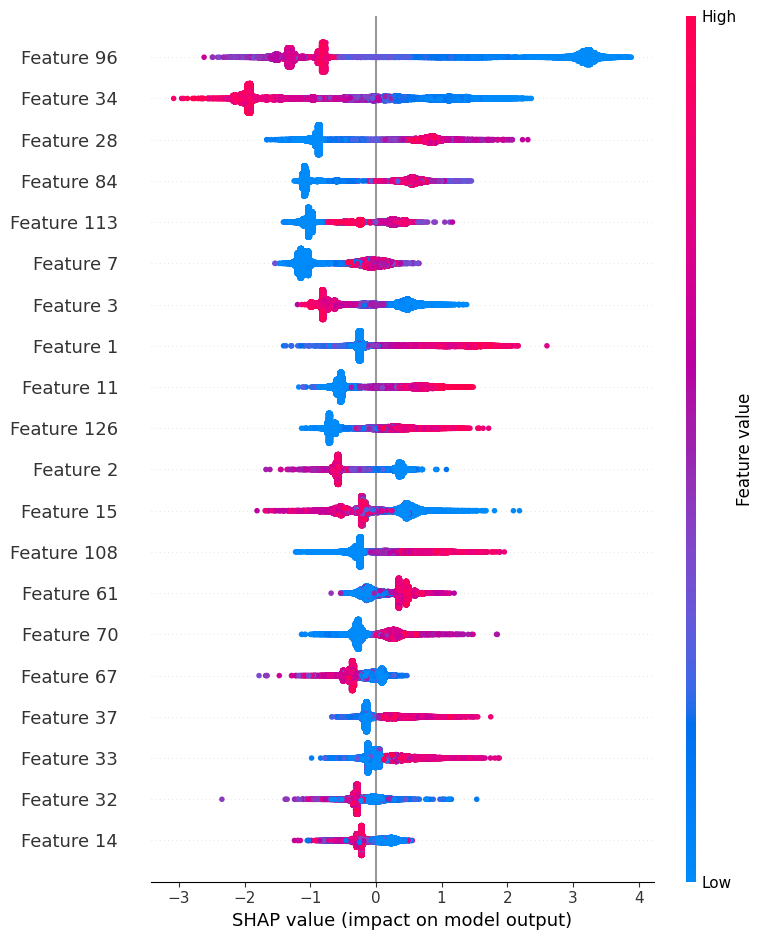

In [66]:
shap.initjs()
shap.summary_plot(shap_values, X_val)

In [67]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.986345227670753


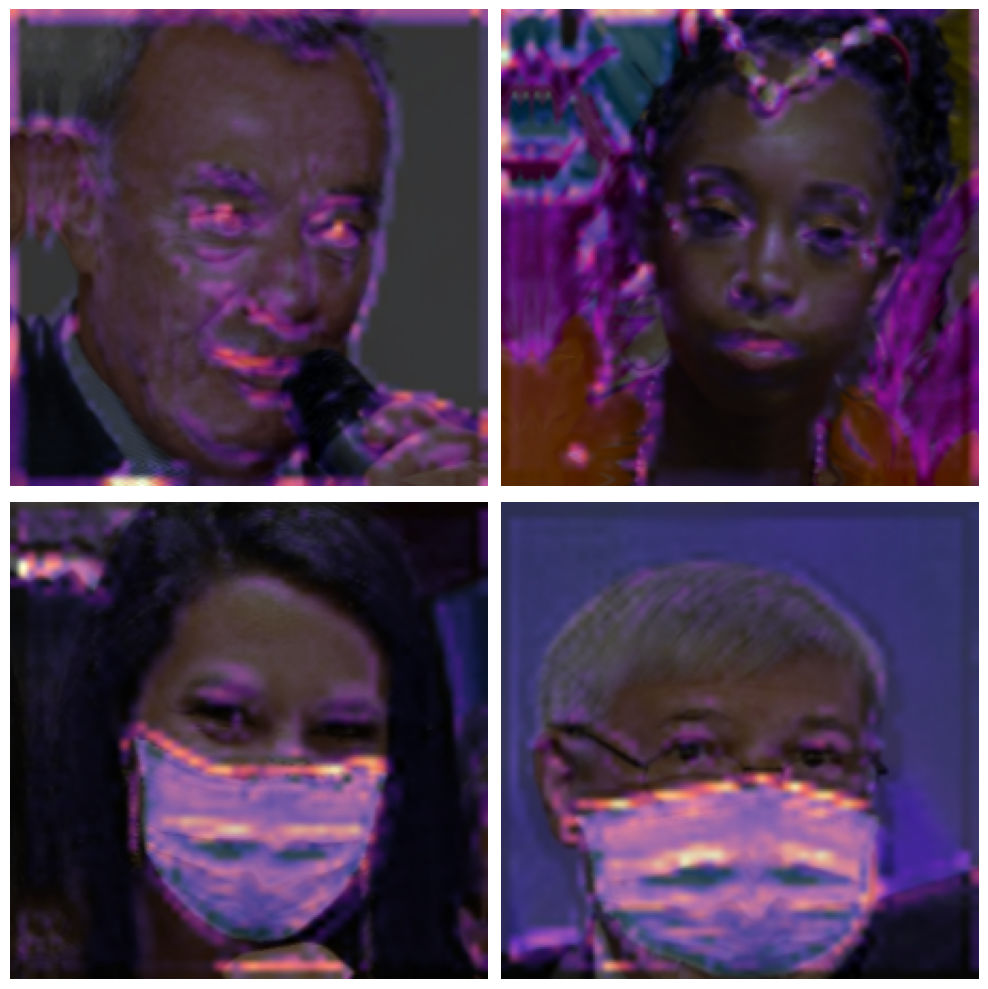

In [72]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=fcn_modelsimple,
                         last_conv_layer_name="sequential",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)

In [71]:
fcn_modelsimple.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 56, 56, 64)     │        24,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,610 (377.39 KB)

 Trainable params: 32,128 (125.50 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 64,258 (251.01 KB)